In [1]:
!gdown https://drive.google.com/u/0/uc?id=1-OdmzC3JvmUsZUMrNAKPnu8ZM7EeSK04

Downloading...
From: https://drive.google.com/u/0/uc?id=1-OdmzC3JvmUsZUMrNAKPnu8ZM7EeSK04
To: /content/skin_lesion.zip
50.2MB [00:00, 160MB/s] 


In [2]:
! unzip -qq skin_lesion.zip

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision 
from tensorflow.keras import backend as K
#from models import DRRMSAN_multiscale_attention


(192, 256, 3)


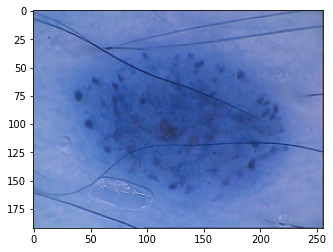

In [5]:
import glob
import cv2
img_files = glob.glob('trainx/*.bmp')
img = cv2.imread(img_files[0])
plt.imshow(img)
print(img.shape)

In [6]:
PATH = ""

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

#IMG_SIZE = 256
EPOCHS = 5
BATCH = 2
LR = 1e-5

In [8]:
def load_data(path, split=0.2):

  # images_list = sorted(glob(os.path.join(path, "trainx/*.bmp")))
  # masks_list = sorted(glob(os.path.join(path, "trainy/*.bmp")))

  import sys
  import glob
  from tqdm import tqdm
  #insert :: sys.path.insert(0, '../../')
  
  ############################## insert:: add ../ before two
  img_files = glob.glob('trainx/*.bmp')
  msk_files = glob.glob('trainy/*.bmp')

  images_list = []
  masks_list = []

  for img_fl in tqdm(img_files):
    if(img_fl.split('.')[-1]=='bmp'):
      images_list.append(img_fl)
      # insert :: img_msk = "../trainy/Y_img_"+str(img_fl.split('.')[2]).split('_')[-1]+".bmp"
      img_msk = "trainy/Y_img_"+str(img_fl.split('.')[0]).split('_')[-1]+".bmp"
      #print("----",img_msk)
      #break
      masks_list.append(img_msk)
  
  tot_size = len(images_list)
  test_size = int(split * tot_size)
  val_size = int(split * (tot_size - test_size))

  x_train, x_val = train_test_split(images_list, test_size=val_size, random_state=42)
  y_train, y_val = train_test_split(masks_list, test_size=val_size, random_state=42)

  x_train, x_test = train_test_split(x_train, test_size=test_size, random_state=42)
  y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [9]:
def read_img(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_COLOR)
    tmp = cv2.resize(tmp, (256, 192))
    tmp = tmp/255.0
    return tmp

def read_mask(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    tmp = cv2.resize(tmp, (256, 192))
    tmp = tmp/255.0
    tmp = np.expand_dims(tmp, axis=-1)
    return tmp

(192, 256, 3)


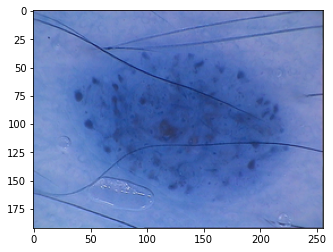

In [10]:
import glob
img_files = glob.glob('trainx/*.bmp')
tmp = cv2.imread(img_files[0], cv2.IMREAD_COLOR)
tmp = cv2.resize(tmp, (256, 192))
tmp = tmp/255.0
plt.imshow(tmp)
print(tmp.shape)

In [11]:
def tf_parse(a, b):
    def _parse(a, b):
        a = read_img(a)
        b = read_mask(b)
        return a, b

    a, b = tf.numpy_function(_parse, [a, b], [tf.float64, tf.float64])
    a.set_shape([192, 256, 3])
    b.set_shape([192, 256, 1])
    return a, b

def tf_dataset(a, b, batch=32):
    data = tf.data.Dataset.from_tensor_slices((a, b))
    data = data.map(tf_parse)
    data = data.batch(batch)
    data = data.repeat()
    return data

In [12]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data(PATH)

print("Training data: ", len(x_train))
print("Validation data: ", len(x_val))
print("Testing data: ", len(x_test))


100%|██████████| 200/200 [00:00<00:00, 91819.26it/s]

Training data:  128
Validation data:  32
Testing data:  40


In [13]:
def read_and_rgb(a):
    a = cv2.imread(a)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

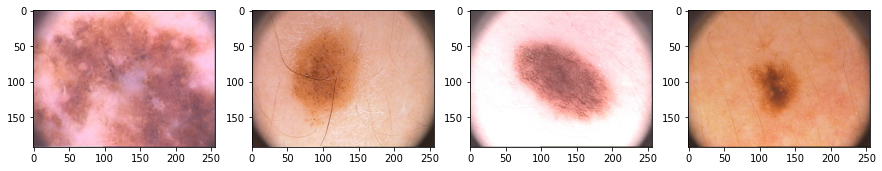

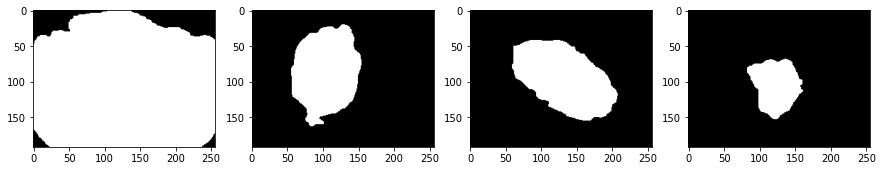

In [14]:
fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(x_test[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(x_test[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(x_test[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(x_test[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(y_test[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(y_test[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(y_test[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(y_test[3]))
imgplot.set_clim(0.0, 1.4)

In [15]:
#!/usr/bin/env python3
# encoding: utf-8
# @Time    : 01/12/2020 15:56
# @Author  : Jimut Bahan Pal

from tqdm import tqdm
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import Recall, Precision 


# https://stackoverflow.com/questions/55809286/how-to-create-a-custom-keras-layer-min-pooling-but-ignore-zeros
# Minpool2D implementation

def MinPooling2D(x, pool_size, strides):

    max_val = K.max(x) + 1 # we gonna replace all zeros with that value
    # replace all 0s with very high numbers
    is_zero = max_val * K.cast(K.equal(x,0), dtype=K.floatx())
    x = is_zero + x

    # execute pooling with 0s being replaced by a high number
    min_x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))

    # depending on the value we either substract the zero replacement or not
    is_result_zero = max_val * K.cast(K.equal(min_x, max_val), dtype=K.floatx()) 
    min_x = min_x - is_result_zero

    return min_x # concatenate on channel











##=================================================
from tensorflow.keras import layers
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, \
    add, multiply, AveragePooling2D, SpatialDropout2D, Subtract, average
from tensorflow.keras import initializers
##=================================================




def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def attention_up_and_concate(down_layer, layer, filters):
    '''
    Attention up and concatenate layer

    Arguments:
        down_layer {keras layer} -- layer coming from the down
        layer {keras layer} -- layer coming from the top
        filters {int} -- number of channels in image

    Returns:
        [keras layer] -- [output layer]
    '''
    
    # up = Conv2DTranspose(out_channel, [3,  3], strides=[3,  3])(down_layer)
    #up = UpSampling2D(size=(2, 2))(down_layer)

    layer = proposed_attention_block_2d(down_layer, layer, filters)

    # if data_format == 'channels_first':
    #     my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    # else:
    #     my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    #concate = my_concat([down_layer, layer])
    return layer



def attention_block_2d(ms_conv, res_block, filters):
    '''
    Attention block

    Arguments:
        ms_conv {keras layer} -- layer coming from the multi resolution convolution
        res_block {keras layer} -- layer coming from the residual block
        filters {int} -- number of channels in image

    Returns:
        [keras layer] -- [output layer]
    '''

    # theta_x(?,g_height,g_width,filters)
    theta_x = Conv2D(filters, [1, 1], strides=[1, 1])(ms_conv)

    # phi_g(?,g_height,g_width,filters)
    phi_g = Conv2D(filters, [1, 1], strides=[1, 1])(res_block)

    # f(?,g_height,g_width,filters)
    f = Activation('relu')(add([theta_x, phi_g]))

    # psi_f(?,g_height,g_width,1)
    psi_f = Conv2D(1, [1, 1], strides=[1, 1])(f)
    rate = Activation('sigmoid')(psi_f)

    # rate(?,x_height,x_width)
    # att_x(?,x_height,x_width,x_channel)
    att_x = multiply([ms_conv, rate])

    return att_x



def proposed_attention_block_2d(ms_conv, res_block, filters):
    '''
    Proposed Attention block

    Arguments:
        ms_conv {keras layer} -- layer coming from the multi resolution convolution
        res_block {keras layer} -- layer coming from the residual block
        filters {int} -- number of channels in image

    Returns:
        [keras layer] -- [output layer]
    '''

    theta_x = Conv2D(filters, [1,  1], strides=[1, 1], padding='same')(ms_conv)
    joint_conv_2x2 = Conv2D(filters, (2, 2), strides=(1, 1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(theta_x)
    conv_3x3 = SpatialDropout2D(0.5)(Activation('relu')(Conv2D(filters, (3, 3), strides=(1, 1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(joint_conv_2x2)))
    conv_5x5 = SpatialDropout2D(0.5)(Activation('relu')(Conv2D(filters, (5, 5), strides=(1, 1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(joint_conv_2x2)))
    conv_7x7 = SpatialDropout2D(0.5)(Activation('relu')(Conv2D(filters, (7, 7), strides=(1, 1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(joint_conv_2x2)))
    add_3x3_5x5 = add([conv_3x3, conv_5x5])
    mult_3x3_5x5 = multiply([conv_3x3, conv_5x5]) #multiply([conv_3x3, conv_5x5])#Subtract()([conv_3x3, conv_5x5])
    add_3x3_5x5_7x7 = Activation('sigmoid')(add([add_3x3_5x5, conv_7x7]))
    mul_3x3_5x5_7x7 = Activation('sigmoid')(multiply([mult_3x3_5x5, conv_7x7]))#multiply([mult_3x3_5x5, conv_7x7]))) # Subtract()([mult_3x3_5x5, conv_7x7])
    add_1x1_upper = Activation('sigmoid')(Conv2D(filters, [1,  1], strides=[1, 1], padding='same')(add_3x3_5x5_7x7))
    mult_1x1_lower = Activation('sigmoid')(Conv2D(filters, [1,  1], strides=[1, 1], padding='same')(mul_3x3_5x5_7x7))
    resampler_down_upper = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(add_1x1_upper) #AveragePooling2D
    resampler_down_lower = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(mult_1x1_lower)
    output_ms_conv_res_block = multiply([resampler_down_upper, resampler_down_lower])

    theta_x_rb = Conv2D(filters, [1,  1], strides=[1, 1], padding='same')(res_block)
    joint_conv_2x2_rb = Conv2D(filters, (2, 2), strides=(1, 1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(theta_x_rb)
    conv_3x3_rb = SpatialDropout2D(0.5)(Activation('relu')(Conv2D(filters, (3, 3), strides=(1, 1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(joint_conv_2x2_rb)))
    conv_5x5_rb = SpatialDropout2D(0.5)(Activation('relu')(Conv2D(filters, (5, 5), strides=(1, 1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(joint_conv_2x2_rb)))
    conv_7x7_rb = SpatialDropout2D(0.5)(Activation('relu')(Conv2D(filters, (7, 7), strides=(1, 1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(joint_conv_2x2_rb)))
    add_3x3_5x5_rb = add([conv_3x3_rb, conv_5x5_rb])
    mult_3x3_5x5_rb = multiply([conv_3x3_rb, conv_5x5_rb])#multiply([conv_3x3_rb, conv_5x5_rb]) #Subtract()([conv_3x3_rb, conv_5x5_rb])
    add_3x3_5x5_7x7_rb = Activation('sigmoid')(add([add_3x3_5x5_rb, conv_7x7_rb]))
    mul_3x3_5x5_7x7_rb = Activation('sigmoid')(multiply([mult_3x3_5x5_rb, conv_7x7_rb]))#multiply([mult_3x3_5x5_rb, conv_7x7_rb]))) # Subtract()([mult_3x3_5x5_rb, conv_7x7_rb])
    add_1x1_upper_rb = Activation('sigmoid')(Conv2D(filters, [1,  1], strides=[1, 1], padding='same')(add_3x3_5x5_7x7_rb))
    mult_1x1_lower_rb = Activation('sigmoid')(Conv2D(filters, [1, 1], strides=[1, 1], padding='same')(mul_3x3_5x5_7x7_rb))
    resampler_down_upper_rb = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(add_1x1_upper_rb)
    resampler_down_lower_rb = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(mult_1x1_lower_rb)
    output_ms_conv_res_block_rb = multiply([resampler_down_upper_rb, resampler_down_lower_rb])
    
    attn_outputs_mult = Activation('sigmoid')(multiply([output_ms_conv_res_block, output_ms_conv_res_block_rb]))
    attn_output_1 = UpSampling2D(size=(2, 2))(attn_outputs_mult)
    attn_output = multiply([attn_output_1, theta_x_rb])
    return attn_output


    

def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


# Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def rec_res_block(input_layer, filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],
                  padding='same'):
  skip_layer = input_layer
  layer = skip_layer
  for j in range(2):
    for i in range(2):
      if i == 0:
        layer1 = Conv2D(filters, kernel_size, strides=stride, padding=padding)(layer)
        if batch_normalization:
          layer1 = BatchNormalization()(layer1)
        layer1 = Activation('relu')(layer1)
      layer1 = Conv2D(filters, kernel_size, strides=stride, padding=padding)(add([layer1, layer]))
      if batch_normalization:
        layer1 = BatchNormalization()(layer1)
      layer1 = Activation('relu')(layer1)
    layer = layer1
  out_layer = add([layer, skip_layer])
  return out_layer


def DRRMSAN_multiscale_attention(height, width, n_channels):
    '''
    DRRMSAN Multiscale Attention Model

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    # use average pool, maxpool and minpool to create different volumes of
    # multiscaling, minpool is used here as a sort of regularizer noise in the feature
    # space.  1/2 th the original scale first.

    inp_1_2I = AveragePooling2D(pool_size=(2, 2))(inputs)
    inp_1_2I_mxpool = MaxPooling2D(pool_size=(2, 2))(inputs)
    inp_1_2I_minpool = MinPooling2D(inputs, pool_size=(2,2), strides=(1,1))
    """
    tf.image.resize(
              inputs, (int(height * 1/2), int(width * 1/2)), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
              antialias=False, name=None
              )
    """
    # 1/4 rth the original scale
    inp_1_4I = AveragePooling2D(pool_size=(2, 2))(inp_1_2I)
    inp_1_4I_mxpool = MaxPooling2D(pool_size=(2, 2))(inp_1_2I_mxpool)
    inp_1_4I_minpool = MinPooling2D(inp_1_2I_minpool, pool_size=(2,2), strides=(1,1))
    #inp_1_4I_minpool = MaxPooling2D(pool_size=(2, 2))(inp_1_2I_mxpool)
    """
    tf.image.resize(
              inputs, (int(height * 1/4), int(width * 1/4)), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
              antialias=False, name=None
              )
    """
    # 1/8 th the original scale
    inp_1_8I = AveragePooling2D(pool_size=(2, 2))(inp_1_4I)
    inp_1_8I_mxpool = MaxPooling2D(pool_size=(2, 2))(inp_1_4I_mxpool)
    inp_1_8I_minpool = MinPooling2D(inp_1_4I_minpool, pool_size=(2,2), strides=(1,1))
    """
              tf.image.resize(
              inputs, (int(height * 1/8), int(width * 1/8)), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
              antialias=False, name=None
              )
    """
    # just pass through some conv and add
    # for adding to multi res block 2, 32 filters
    # use 50 - 50 
    # Conv2D(filters, (3, 3), strides=(1,1), padding='same'
    
    # using different ratios for the volumes, can be improved by using
    # Bayesian Optimization

    total_1_2I = 51
    per_mx_pool_1_2I = int(0.40 * total_1_2I)
    per_avg_pool_1_2I = int(0.30 * total_1_2I)
    per_min_pool_1_2I = int(0.05 * total_1_2I)
    per_down_1_2I = int(total_1_2I - (per_mx_pool_1_2I + per_avg_pool_1_2I + per_min_pool_1_2I))

    mrb2_1_2I_avgpool = Conv2D(per_avg_pool_1_2I, (3, 3), strides=(1,1), padding='same', name='side_left_1_avgpool')(inp_1_2I) 
    mrb2_1_2I_mxpool = Conv2D(per_mx_pool_1_2I, (3, 3), strides=(1,1), padding='same', name='side_left_1_mxpool')(inp_1_2I_mxpool)
    mrb2_1_2I_minpool = Conv2D(per_min_pool_1_2I, (3, 3), strides=(1,1), padding='same', name='side_left_1_minpool')(inp_1_2I_minpool)

    total_1_4I = 105
    per_mx_pool_1_4I = int(0.40 * total_1_4I)
    per_avg_pool_1_4I = int(0.30 * total_1_4I)
    per_min_pool_1_4I = int(0.05 * total_1_4I)
    # 52% to the down layer
    per_down_1_4I = int(total_1_4I - (per_mx_pool_1_4I + per_avg_pool_1_4I + per_min_pool_1_4I))

    mrb3_1_4I_avgpool = Conv2D(per_avg_pool_1_4I, (3, 3), strides=(1,1), padding='same', name='side_left_2_avgpool')(inp_1_4I) 
    mrb3_1_4I_mxpool = Conv2D(per_mx_pool_1_4I, (3, 3), strides=(1,1), padding='same', name='side_left_2_mxpool')(inp_1_4I_mxpool) 
    mrb3_1_4I_minpool = Conv2D(per_min_pool_1_4I, (3, 3), strides=(1,1), padding='same', name='side_left_2_minpool')(inp_1_4I_minpool) 

    total_1_8I = 212
    per_mx_pool_1_8I = int(0.40 * total_1_8I)
    per_avg_pool_1_8I = int(0.30 * total_1_8I)
    per_min_pool_1_8I = int(0.05 * total_1_8I)
    per_down_1_8I = int(total_1_8I - (per_mx_pool_1_8I + per_avg_pool_1_8I + per_min_pool_1_8I))

    mrb4_1_8I_avgpool = Conv2D(per_avg_pool_1_8I, (3, 3), strides=(1,1), padding='same', name='side_left_3_avgpool')(inp_1_8I)
    mrb4_1_8I_mxpool = Conv2D(per_mx_pool_1_8I, (3, 3), strides=(1,1), padding='same', name='side_left_3_mxpool')(inp_1_8I_mxpool)
    mrb4_1_8I_minpool = Conv2D(per_min_pool_1_8I, (3, 3), strides=(1,1), padding='same', name='side_left_3_minpool')(inp_1_8I_minpool)


    #==================================================================

    mresblock1 = MultiResBlock(32, inputs)
    mresblock1 = rec_res_block(mresblock1, 51)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    #===================
    pool1 = Conv2D(per_down_1_2I, (3, 3), strides=(1,1), padding='same')(pool1)
    left_block_1 = concatenate([pool1, mrb2_1_2I_avgpool, mrb2_1_2I_mxpool, mrb2_1_2I_minpool])
    #left_block_1 = rec_res_block(left_block_1, total_1_2I)
    #pool1 = multiply([pool1, mrb2_1_2I])
    #pool1 = proposed_attention_block_2d(pool1, mresblock1,filters=51)
    #===================
    mresblock1 = ResPath(32, 4, mresblock1)

    
    mresblock2 = MultiResBlock(32*2, left_block_1)
    mresblock2 = rec_res_block(mresblock2, 105)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    #===================
    pool2 = Conv2D(per_down_1_4I, (3, 3), strides=(1,1), padding='same')(pool2)
    left_block_2 = concatenate([pool2, mrb3_1_4I_avgpool, mrb3_1_4I_mxpool, mrb3_1_4I_minpool])
    #left_block_2 = rec_res_block(left_block_2, total_1_4I)
    #pool2 = multiply([pool2, mrb3_1_4I])
    #pool2 = proposed_attention_block_2d(pool2, mresblock2,filters=105)
    #===================
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, left_block_2)
    mresblock3 = rec_res_block(mresblock3, 212)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    #===================
    pool3 = Conv2D(per_down_1_8I, (3, 3), strides=(1,1), padding='same')(pool3)
    left_block_3 = concatenate([pool3, mrb4_1_8I_avgpool, mrb4_1_8I_mxpool, mrb4_1_8I_minpool])
    left_block_3 = rec_res_block(left_block_3, total_1_8I)
    #pool3 = multiply([pool3, mrb4_1_8I])
    #pool3 = proposed_attention_block_2d(pool3, mresblock3,filters=212)
    #===================
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, left_block_3)
    mresblock4 = rec_res_block(mresblock4, 426)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)


    mresblock5 = MultiResBlock(32*16, pool4)
    mresblock5 = rec_res_block(mresblock5, 853)

    #up6_add =  add([Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4])
    #up6_dra = attention_up_and_concate(Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same', name='up6_dra')(mresblock5), mresblock4,filters=32*8)
    up6 = attention_block_2d(Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same', name='up6')(mresblock5), mresblock4,filters=64)
    up6 = add([up6, mresblock4])
    
    #concatenate([Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)
    mresblock6 = rec_res_block(mresblock6, 426)
    conv_6_up = Conv2D(212, (3, 3), padding='same', activation='relu', name='conv_6_up')(mresblock6)
    conv_6_up = rec_res_block(mresblock6, 426)
    

    #up7_add = add([Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3])
    #up7_dra = attention_up_and_concate(Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same', name='up7_dra')(mresblock6), mresblock3, filters = 32*4)
    up7 = attention_block_2d(Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same', name='up7')(mresblock6), mresblock3, filters = 32*4)
    up7 = add([up7, mresblock3])
    mresblock7 = MultiResBlock(32*4, up7)
    mresblock7 = rec_res_block(mresblock7, 212)
    conv_7_up = Conv2D(105, (3, 3), padding='same', activation='relu', name='conv_7_up')(mresblock7)
    conv_7_up = rec_res_block(mresblock7, 212)
    

    #up8_add = add([Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2])
    #up8_dra = attention_up_and_concate(Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same', name='up8_dra')(mresblock7), mresblock2, filters = 32*2)
    up8 = attention_block_2d(Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same', name='up8')(mresblock7), mresblock2, filters = 32*2)
    up8 = concatenate([up8, mresblock2])#,
    mresblock8 = MultiResBlock(32*2, up8)
    mresblock8 = rec_res_block(mresblock8, 105)
    conv_8_up = Conv2D(51, (3, 3), padding='same', activation='relu', name='conv_8_up')(mresblock8)
    conv_8_up = rec_res_block(conv_8_up, 51)

    #up9_add = add([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(mresblock8), mresblock1])
    #up9_dra = attention_up_and_concate(Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='up9_dra')(mresblock8), mresblock1, filters = 32)
    up9 = attention_block_2d(Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='up9')(mresblock8), mresblock1, filters = 32)
    up9 = add([up9, mresblock1])#
    mresblock9 = MultiResBlock(32, up9)
    mresblock9 = rec_res_block(mresblock9, 51)
    conv_9_up = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_8_up')(mresblock9)
    conv_9_up = rec_res_block(conv_9_up, 32)


    side6 = UpSampling2D(size=(8, 8))(conv_6_up)
    side7 = UpSampling2D(size=(4, 4))(conv_7_up)
    side8 = UpSampling2D(size=(2, 2))(conv_8_up)

    # the conv blocks on the right sides

    out6 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4), name='side_6')(side6) # conv2d_bn(side6, 1, 1, 1, activation='none') #
    out7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4), name='side_7')(side7) # conv2d_bn(side7, 1, 1, 1, activation='none') #
    out8 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4), name='side_8')(side8) # conv2d_bn(side8, 1, 1, 1, activation='none') #

    out9 = conv2d_bn(mresblock9, 1, 3, 3, activation='sigmoid', padding='same')

    # averaging all the output masks obtained at different scales

    out10 = average([out6, out7, out8, out9])

    #conv10 = conv2d_bn(out10, 1, 1, 1, activation='sigmoid')

    model = Model(inputs=[inputs], outputs=[out10])

    return model

In [16]:
model = DRRMSAN_multiscale_attention(height=192, width=256, n_channels=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 8)  216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 256, 8)  24          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 256, 8)  0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [17]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [18]:
train_data = tf_dataset(x_train, y_train, batch=BATCH)
valid_data = tf_dataset(x_val, y_val, batch=BATCH)

In [19]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [20]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ModelCheckpoint("./model_checkpoint", monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir=logdir)
]

In [21]:
train_steps = len(x_train)//BATCH
valid_steps = len(x_val)//BATCH

if len(x_train) % BATCH != 0:
    train_steps += 1
if len(x_val) % BATCH != 0:
    valid_steps += 1

In [22]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/5
64/64 [==============================] - 78s 603ms/step - loss: 0.5164 - dice_coef: 0.4842 - recall: 0.9577 - precision: 0.3777 - val_loss: 0.6402 - val_dice_coef: 0.3604 - val_recall: 0.0903 - val_precision: 1.0000
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 2/5
64/64 [==============================] - 35s 554ms/step - loss: 0.3372 - dice_coef: 0.6634 - recall: 0.7477 - precision: 0.7956 - val_loss: 0.7164 - val_dice_coef: 0.2842 - val_recall: 0.0060 - val_precision: 1.0000
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 3/5
64/64 [==============================] - 35s 552ms/step - loss: 0.2805 - dice_coef: 0.7201 - recall: 0.7649 - precision: 0.8674 - val_loss: 0.8075 - val_dice_coef: 0.1931 - val_recall: 0.0029 - val_precision: 1.0000
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
Epoch 4/5
64/64 [==============================] - 35s 550ms/step - loss: 0.2473 - dice_coef: 0.7533 - recall: 0.8019 - precision: 0.9093 -

In [23]:
model.save_weights("skin_drrmsan_150e.h5")
model.save("skin_drrmsan_with_weight_150e.h5")

In [24]:
# Run this module only while loading the pre-trained model.
model = load_model('skin_drrmsan_with_weight_150e.h5',custom_objects={'dice_loss': dice_loss,'dice_coef':dice_coef})
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 8)  216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 256, 8)  24          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 256, 8)  0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [25]:

def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union
    

In [28]:
from glob import glob

test_data = tf_dataset(x_test, y_test, batch=BATCH)

test_steps = (len(x_test)//BATCH)

if len(x_test) % BATCH != 0:
  test_steps += 1

model.evaluate(test_data, steps=test_steps)

TypeError: ignored

In [28]:
! mkdir results

In [29]:
def read_img(path):
    xt = cv2.imread(path, cv2.IMREAD_COLOR)
    xt = cv2.cvtColor(xt, cv2.COLOR_BGR2RGB)
    xt = cv2.resize(xt, (256, 192))
    xt = xt/255.0
    return xt

def read_mask(path):
    xt = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    xt = cv2.resize(xt, (256, 192))
    xt = np.expand_dims(xt, axis=-1)
    xt = xt/255.0
    return xt

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

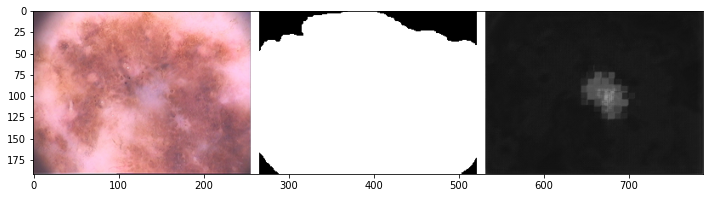

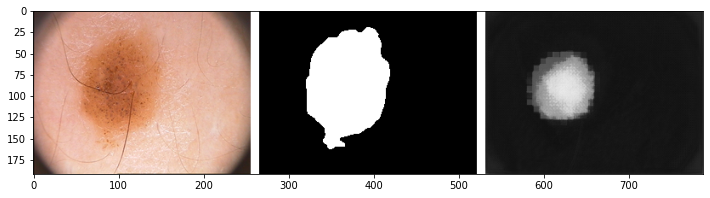

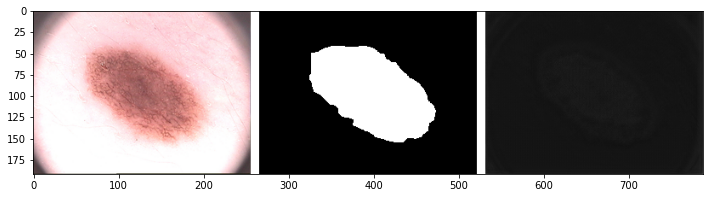

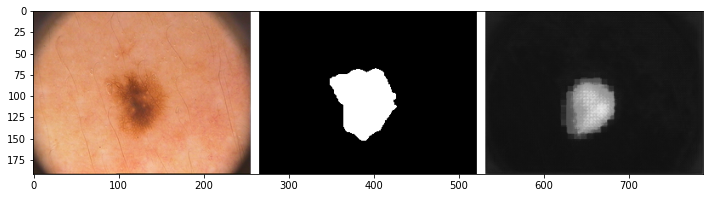

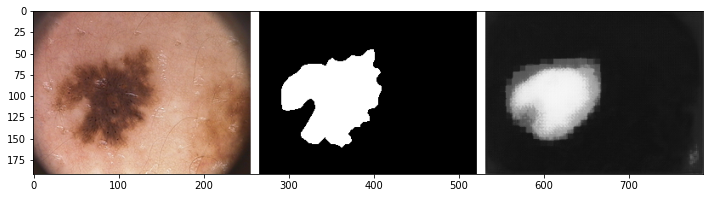

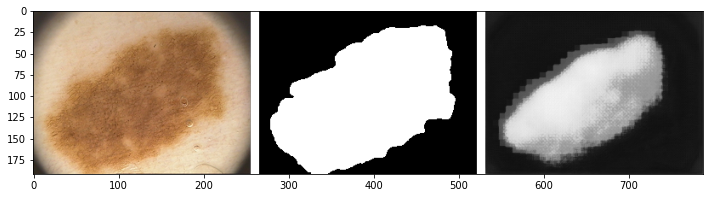

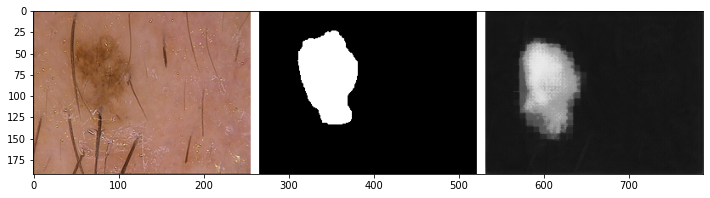

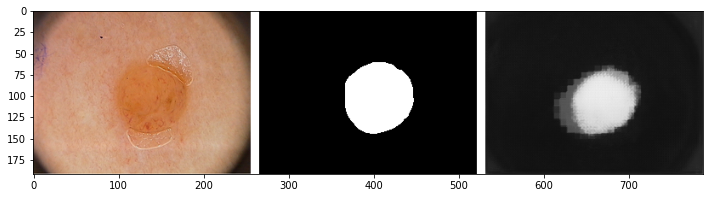

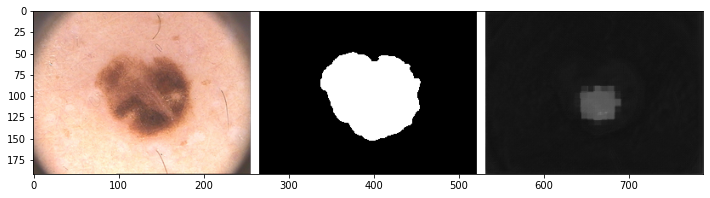

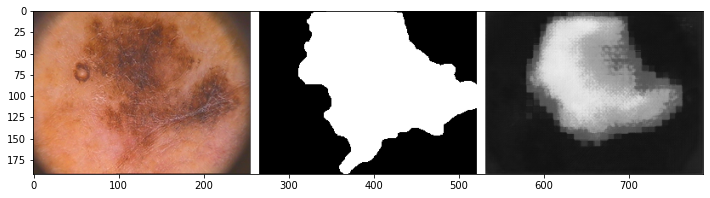

In [30]:
for i, (a, b) in enumerate(zip(x_test[0:10], y_test[0:10])):
    a = read_img(a)
    b = read_mask(b)
    y_pred = model.predict(np.expand_dims(a, axis=0))[0] 
    h, w, _ = a.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        a, white_line,
        mask_parse(b), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    x = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    #plt.savefig('results/'+str(i)+'.png',format='png')
    #plt.close()
